In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sbcbinaryformat import TarStreamer, Writer
from pathlib import Path
from scipy import signal as sg

ana_path = "../LAr10Ana/"
sys.path.insert(0, ana_path)

from GetEvent import GetEvent
from GetHistorian import GetHistorian

In [2]:
def find_offset_correlation(t1_original, t2_original, bin_width=0.0001):
    t1 = np.asarray(t1_original).copy()
    t2 = np.asarray(t2_original).copy()
    t1_0 = t1[0]
    t2_0 = t2[0]
    t1 -= t1_0
    t2 -= t2_0
    
    t_min = min(t1[0], t2[0])
    t_max = max(t1[-1], t2[-1])
    bins = np.arange(t_min, t_max, bin_width)
    hist1, _ = np.histogram(t1, bins=bins)
    hist2, _ = np.histogram(t2, bins=bins)
    
    correlation = sg.correlate(hist1, hist2, mode='full')
    lag = sg.correlation_lags(len(hist1), len(hist2), mode='full')
    lag = lag*bin_width + t1_0 - t2_0
    
    best_lag = lag[np.argmax(correlation)]
    
    return best_lag, correlation, lag

In [87]:
run = "20260112_2"
event = 4
run_path = f"/exp/e961/data/SBC-25-daqdata/{run}.tar"
data = GetEvent(run_path, event, strictMode=False, lazy_load_scintillation=False)
print(data.keys())
digiscope = data["digiscope"]
scint = data["scintillation"]
print(scint.keys())

dict_keys(['acoustics', 'scintillation', 'cam', 'event_info', 'plc', 'digiscope', 'slow_daq', 'run_info', 'run_control'])
dict_keys(['loaded', 'EventCounter', 'TriggerSource', 'GroupMask', 'TriggerMask', 'AcquisitionMask', 'TriggerTimeTag', 'Waveforms', 'length', 'sample_rate'])


digi: 4058, caen:49500


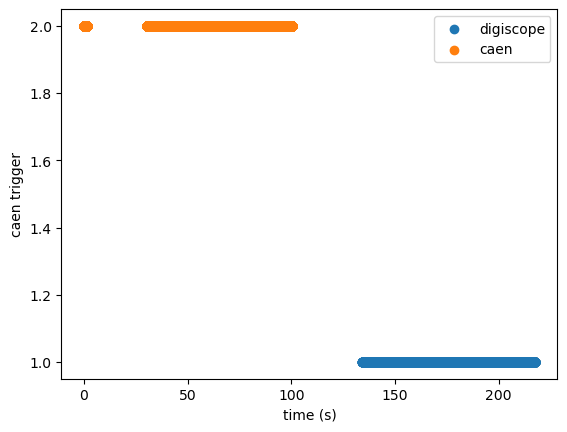

In [88]:
di = digiscope["DI"][:,0]
di_caen = (di & (1<<2)).astype(bool)

digi_time = digiscope["t_ticks"].astype(np.int64)
wraps_ind = sg.find_peaks(np.abs(np.diff(digi_time)), height=2**31)[0]
for i in wraps_ind:
    digi_time[i+1:]+=2**32
digi_clock = 40e6
digi_time = digi_time/digi_clock
digi_time_caen = digi_time[di_caen]
# digi_time_caen -= digi_time_caen[0]
digi_caen_points = np.full_like(digi_time_caen, 1)

scint_time = scint["TriggerTimeTag"].astype(np.int64)
wraps_ind = sg.find_peaks(np.abs(np.diff(scint_time)), height=2**30)[0]

for i in wraps_ind:
    scint_time[i+1:]+=2**31
scint_clock=125e6
scint_time = scint_time/scint_clock
# scint_time -= scint_time[0]
scint_points = np.full_like(scint_time, 2)
print(f"digi: {len(digi_time_caen)}, caen:{len(scint_time)}")

plt.scatter(digi_time_caen, digi_caen_points, label="digiscope")
plt.scatter(scint_time, scint_points, label="caen")
plt.xlabel("time (s)")
plt.ylabel("caen trigger")
plt.legend()
plt.show()

In [ ]:
t, corr, lag = find_offset_correlation(digi_time_caen, scint_time, bin_width=1e-6)
print(f"t: {t}")
plt.plot(lag, corr)
plt.xlabel("lag (s)")
plt.ylabel("correlation")
plt.xlim(t-0.1, t+0.1)
plt.show()

plt.scatter(digi_time_caen-t, digi_caen_points, label="digiscope")
plt.scatter(scint_time, scint_points, label="caen")
plt.xlabel("time (s)")
plt.ylabel("caen trigger")
plt.legend()
plt.xlim(50, 50.1)
plt.ylim(-3,5)
plt.show()

t: 103.90646135200001
